In [67]:
#SERVER

class Server:
    def __init__(self, server_id, ip_address, total_cpu, total_memory, total_bandwidth, network_distance, hosted_services=None):
        self.server_id = server_id
        self.network_distance = network_distance
        self.ip_address = ip_address
        self.total_cpu = total_cpu
        self.total_memory = total_memory
        self.total_bandwidth = total_bandwidth
        self.available_cpu = total_cpu  # Initially, all resources are available
        self.available_memory = total_memory
        self.available_bandwidth = total_bandwidth
        self.hosted_services = hosted_services if hosted_services is not None else []

    def calculate_agg_resources(self): # not planning to use it now
        """Calculate the average resource utilization as an aggregate metric."""
        return (self.available_cpu + self.available_memory + self.available_bandwidth) / 3

    
    def add_service_function(self, service_function):
        self.hosted_services.append(service_function)

    def remove_service_function(self, service_function):
        self.hosted_services.remove(service_function)

    def list_service_functions(self):
        return self.hosted_services
    
    def calculate_latency_priority(self, microservice):
        """Simulate latency based on network distance and server load, in real life we would have the microservice ping the server."""
        base_latency = self.network_distance * 0.5  # Simplified calculation
        return base_latency
    
    def meets_requirements(self, cpu_requirement, memory_requirement, bandwidth_requirement):
        """Check if the server has enough resources to host the microservice."""
        return (self.available_cpu >= cpu_requirement and
                self.available_memory >= memory_requirement and
                self.available_bandwidth >= bandwidth_requirement)
    def deploy_microservice(self, microservice):
        #Deploy service and subtract required resources
        if not self.meets_requirements(microservice.cpu_requirement, microservice.memory_requirement, microservice.bandwidth_requirement):
            return False  # Deployment fails due to insufficient resources
        
        self.available_cpu -= microservice.cpu_requirement
        self.available_memory -= microservice.memory_requirement
        self.available_bandwidth -= microservice.bandwidth_requirement
        self.hosted_services.append(microservice.service_id)
        microservice.server=self
        return True

    def remove_microservice(self, microservice):
        #remove a service and re-add used resources to server
        if microservice.service_id in self.hosted_services:
            self.available_cpu += microservice.cpu_requirement
            self.available_memory += microservice.memory_requirement
            self.available_bandwidth += microservice.bandwidth_requirement
            self.hosted_services.remove(microservice.service_id)
            microservice.server= None

    def __str__(self):
        return (f"Server(ID={self.server_id}, IP={self.ip_address}, "
                f"CPU={self.available_cpu}, Memory={self.available_memory}, "
                f"Bandwidth={self.available_bandwidth}, Distance={self.network_distance}, "
                f"Hosted_Services={len(self.hosted_services)})")

       


#MICROSERVICE  
class Microservice:
    def __init__(self, service_id, name, cpu_requirement, memory_requirement, bandwidth_requirement, latency_threshold, server=None):
        self.service_id = service_id
        self.name = name
        self.cpu_requirement = cpu_requirement
        self.memory_requirement = memory_requirement
        self.bandwidth_requirement = bandwidth_requirement
        self.latency_threshold = latency_threshold
        self.server = server  # HOST SERVER

    def __str__(self):
        server_id = self.server.server_id if self.server else "Not deployed"
        return (f"Microservice(name={self.name}, CPU={self.cpu_requirement}, "
                f"Memory={self.memory_requirement}, Bandwidth={self.bandwidth_requirement}, "
                f"Latency Threshold={self.latency_threshold}ms, Server={server_id})")




# GRAPH
import numpy as np
import heapq
import networkx as nx
import matplotlib.pyplot as plt
class NetworkGraph:
    def __init__(self):
        self.nodes = {}  # Stores server objects with server_id as key
        self.edges = {}  # Stores connections and their properties

    def add_server(self, server):
        """Add a server"""
        self.nodes[server.server_id] = server
        self.edges[server.server_id] = []

    def connect_servers(self, server_id1, server_id2, latency, bandwidth):
        """Connect two servers with specified latency and bandwidth."""
        if server_id1 not in self.nodes or server_id2 not in self.nodes:
            raise ValueError("One or both of the servers not found in the graph.")
        
        connection_info = {'latency': latency, 'bandwidth': bandwidth}
        self.edges[server_id1].append((server_id2, connection_info))
        self.edges[server_id2].append((server_id1, connection_info))

    def get_server_connections(self, server_id):
        """Retrieve a server's connections and their properties."""
        return self.edges.get(server_id, [])

    def __str__(self):
        """Provide a string overload of the graph for debugging purposes."""
        description = "Network Graph:\n"
        for server_id in self.nodes:
            description += f"Server {server_id} connections: {self.edges[server_id]}\n"
        return description
    
    def find_shortest_path(self, start_server_id, end_server_id):
        """Find the shortest path from start to end server based on latency using Dijkstra"""
        distances = {server_id: float('inf') for server_id in self.nodes}
        distances[start_server_id] = 0
        priority_queue = [(0, start_server_id)]
        predecessor = {server_id: None for server_id in self.nodes}

        while priority_queue:
            current_distance, current_server_id = heapq.heappop(priority_queue)
            if current_server_id == end_server_id:
                break

            for neighbor, connection_info in self.get_server_connections(current_server_id):
                distance = current_distance + connection_info['latency']
                if distance < distances[neighbor]:
                    distances[neighbor] = distance
                    predecessor[neighbor] = current_server_id
                    heapq.heappush(priority_queue, (distance, neighbor))

        # Reconstructing path
        path = []
        current = end_server_id
        while current is not None:
            path.append(current)
            current = predecessor[current]
        path.reverse()

        return path if path[0] == start_server_id else None
    
    def average_network_latency(self):
        """Calculate the average latency across all connections in the graph."""
        total_latency, count = 0, 0
        for server_id in self.edges:
            for connection in self.edges[server_id]:
                _, connection_info = connection
                total_latency += connection_info['latency']
                count += 1
        return total_latency / count if count > 0 else 0
    

    def update_connection(self, server_id1, server_id2, latency=None, bandwidth=None):
        """Update the properties of a connection between two servers."""
        if server_id1 in self.edges and server_id2 in self.edges:
            for i, (target_id, info) in enumerate(self.edges[server_id1]):
                if target_id == server_id2:
                    if latency is not None:
                        self.edges[server_id1][i][1]['latency'] = latency
                    if bandwidth is not None:
                        self.edges[server_id1][i][1]['bandwidth'] = bandwidth
                    break
            # Bidirectional repeat for the reverse connection
            for i, (target_id, info) in enumerate(self.edges[server_id2]):
                if target_id == server_id1:
                    if latency is not None:
                        self.edges[server_id2][i][1]['latency'] = latency
                    if bandwidth is not None:
                        self.edges[server_id2][i][1]['bandwidth'] = bandwidth
                    break
        else:
            raise ValueError("One or both of the servers not found in the graph.")
        

    def calculate_load_imbalance(self):
        """
        Calculate the imbalance in server load across the network.
        
        Returns a dictionary with the standard deviation of CPU, memory, and bandwidth utilizations,
            indicating the level of imbalance. Lower values indicate a more balanced load.
        """
        cpu_utilizations = []
        memory_utilizations = []
        bandwidth_utilizations = []
        
        for server_id, server in self.nodes.items():
            cpu_util = (server.total_cpu - server.available_cpu) / server.total_cpu if server.total_cpu else 0
            memory_util = (server.total_memory - server.available_memory) / server.total_memory if server.total_memory else 0
            bandwidth_util = (server.total_bandwidth - server.available_bandwidth) / server.total_bandwidth if server.total_bandwidth else 0
            
            cpu_utilizations.append(cpu_util)
            memory_utilizations.append(memory_util)
            bandwidth_utilizations.append(bandwidth_util)
        
        # Calculate standard deviation for each resource utilization
        cpu_std = np.std(cpu_utilizations) if cpu_utilizations else 0
        memory_std = np.std(memory_utilizations) if memory_utilizations else 0
        bandwidth_std = np.std(bandwidth_utilizations) if bandwidth_utilizations else 0
        
        return {
            'cpu_std': cpu_std,
            'memory_std': memory_std,
            'bandwidth_std': bandwidth_std
        }
    def get_average_latency_to_other_servers(self, server_id):
        """Calculate the average latency from a specified server to all other servers."""
        if server_id not in self.edges:
            raise ValueError(f"Server {server_id} not found in the graph.")
        
        total_latency = 0
        connections = 0
        for connection in self.edges[server_id]:
            neighbor_id, connection_info = connection
            total_latency += connection_info['latency']
            connections += 1
        
        # We don't divide by zero if a server has no connections
        if connections == 0:
            return float('inf')  
        
        return total_latency / connections
    
    def visualize(self):
        """Visualize the network graph."""
        G = nx.Graph()
        for server_id in self.nodes:
            G.add_node(server_id)
        for server_id, connections in self.edges.items():
            for target_id, info in connections:
                G.add_edge(server_id, target_id, weight=info['latency'])
        
        pos = nx.spring_layout(G)  # positions for all nodes
        nx.draw_networkx_nodes(G, pos, node_size=700)
        nx.draw_networkx_edges(G, pos, width=2)
        nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
        
        edge_labels = dict([((u, v,), f"{d['weight']}ms")
                            for u, v, d in G.edges(data=True)])
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        
        plt.axis('off')
        plt.show()




#ENVIRONMENT

class MicroserviceDeploymentEnv:
    def __init__(self, graph, microservices):
        self.graph = graph  
        self.original_microservices = microservices
        self.microservices = None
        self.current_microservice_index = -1

        self.current_microservice = None
        self.state_size = None
        self.action_size = len(graph.nodes)  # Dynamically determined by the number of servers in the graph

    def reset(self):
            # Reset the environment to its initial state
            self.microservices = list(self.original_microservices)  # Create a fresh copy of the microservices for the new episode
            self.current_microservice_index = 0  # Reset to the first microservice
            self.current_microservice = self.microservices[self.current_microservice_index]
            
            # Reset servers to their original state
            for server in self.graph.nodes.values():
                server.available_cpu = server.total_cpu
                server.available_memory = server.total_memory
                server.available_bandwidth = server.total_bandwidth
                server.hosted_services.clear()
            
            # Optionally, reset any other environment state variables
            ...
            
            return self.get_state()  # Return the initial state of the environment

    @staticmethod        
    def  normalize(value, min_value, max_value):
        """Normalize a value to 0-1 range for optimal dqn input"""

        return (value - min_value) / (max_value - min_value) if max_value > min_value else 0
    

    def get_state(self):
        # Node features
        x = []  # List to hold node features
        edge_index = [[], []]  # List to hold source and target nodes of each edge
        edge_attr = []  # List to hold edge attributes (optional)

        # Prepare node features (e.g., normalized CPU, memory, bandwidth)
        for server_id, server in self.graph.nodes.items():
            normalized_cpu = self.normalize(server.available_cpu, 0, server.total_cpu)
            normalized_memory = self.normalize(server.available_memory, 0, server.total_memory)
            normalized_bandwidth = self.normalize(server.available_bandwidth, 0, server.total_bandwidth)
            server_features = [normalized_cpu, normalized_memory, normalized_bandwidth]
            x.append(server_features)

        # Prepare edge connections and (optional) edge attributes
        for source_id, connections in self.graph.edges.items():
            for target_id, connection_info in connections:
                source_index = list(self.graph.nodes.keys()).index(source_id)
                target_index = list(self.graph.nodes.keys()).index(target_id)
                edge_index[0].append(source_index)
                edge_index[1].append(target_index)
                # Optional: Prepare edge attributes, e.g., latency
                edge_attr.append([connection_info['latency'], connection_info['bandwidth']])
        
        # Convert lists to tensors
        x_tensor = torch.tensor(x, dtype=torch.float)
        edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
        edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float)

        # Create the PyTorch Geometric Data object
        data = Data(x=x_tensor, edge_index=edge_index_tensor, edge_attr=edge_attr_tensor)

        return data

    def execute_action(self, action):
        # Check if there are any microservices left to deploy
        if self.current_microservice_index >= len(self.microservices):
            # No microservices left, end the episode
            return None, 0, True  # Assuming no state, no reward, and done is True

        # Action is the index corresponding to a server in the graph.nodes dictionary
        server_ids = list(self.graph.nodes.keys())
        try:
            selected_server_id = server_ids[action]
            selected_server = self.graph.nodes[selected_server_id]
            # Deploy the microservice to the selected server
            if selected_server.meets_requirements(
                self.current_microservice.cpu_requirement,
                self.current_microservice.memory_requirement,
                self.current_microservice.bandwidth_requirement
            ):
                success = selected_server.deploy_microservice(self.current_microservice)
                reward = self.calculate_reward(action, success)  # Calculate reward based on action success
                
                # Move to the next microservice, update state
                self.current_microservice_index += 1
                if self.current_microservice_index < len(self.microservices):
                    self.current_microservice = self.microservices[self.current_microservice_index]
                    next_state = self.get_state()  # Get the new state after deployment
                else:
                    # No more microservices to deploy, end of episode
                    next_state = None
                    self.current_microservice = None
                
                # Check if the episode should end
                done = self.current_microservice_index >= len(self.microservices)
                
                return next_state, reward, done
            else:
                # Deployment failed due to insufficient resources try another server
                # or to move to the next microservice
                #penalize and move to the next microservice
                self.current_microservice_index += 1
                if self.current_microservice_index < len(self.microservices):
                    self.current_microservice = self.microservices[self.current_microservice_index]
                    next_state = self.get_state()
                else:
                    next_state = None
                    self.current_microservice = None
                return next_state, -1, self.current_microservice_index >= len(self.microservices)  # Penalize and potentially end episode
        except IndexError:
            # Handle invalid action (e.g., action index out of range)
            return None, -1, False  # Return a default failed state with a penalty but not ending the episode

    
    def calculate_reward(self, action, success):
        """
        Calculate the reward for deploying a microservice based on the action's success and system state.
        
        Parameters:
            action (int): The destination server of the action attempted
            success: Whether the microservice deployment was successful.
        
        Returns the calculated reward for the action.
             
        """
        if not self.current_microservice:
            # No microservice is selected for deployment...system error.
            return -10  # Penalize heavily
        
        server_ids = list(self.graph.nodes.keys())
        try:
            selected_server_id = server_ids[action]
            selected_server = self.graph.nodes[selected_server_id]
        except IndexError:
            # Action led to an invalid server selection
            return -5
        
        if not success:
            # Deployment failed. Penalize to a degree but less than system errors.
            return -2

        # If deployment was successful, positive reward is calculated based on several factors, we can supplement it if necessary
        reward = 0
        
        # Factor 1: Resource Utilization Efficiency. Encourage efficient use of server resources without overloading.

        cpu_utilization = (selected_server.total_cpu - selected_server.available_cpu) / selected_server.total_cpu
        memory_utilization = (selected_server.total_memory - selected_server.available_memory) / selected_server.total_memory
        bandwidth_utilization = (selected_server.total_bandwidth - selected_server.available_bandwidth) / selected_server.total_bandwidth
        
        # Average utilization leads to balanced use of resources.
        avg_utilization = (cpu_utilization + memory_utilization + bandwidth_utilization) / 3
        reward += 5 * avg_utilization  
        
        # Factor 2: Network Performance. Penalize if the deployment significantly impacts network latency or does not meet latency requirements.

        if selected_server.calculate_latency_priority(self.current_microservice) > self.current_microservice.latency_threshold:
            # Penalize for exceeding latency threshold, scaled by how much it was exceeded.
            reward -= 5 * (selected_server.calculate_latency_priority(self.current_microservice) / self.current_microservice.latency_threshold)
        
        # Factor 3: Load Balancing. Reward deployments that help balance the load across the network.
        
        
        load_imbalance = self.graph.calculate_load_imbalance()  # Assess load balance across servers.
        avg_imbalance = (load_imbalance['cpu_std'] + load_imbalance['memory_std'] + load_imbalance['bandwidth_std']) / 3

        reward -= 2 * avg_imbalance  # Penalize based on degree of imbalance to encourage load balancing.
        
        # OTHERS
        
        return reward



import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, num_features, num_actions):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)  # num_features: number of features per node
        self.conv2 = GCNConv(16, num_actions)   # num_actions: number of possible actions

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer
        x = F.relu(self.conv1(x, edge_index))
        # Second GCN layer (outputs Q-values)
        x = self.conv2(x, edge_index)

        return x

class DQN_GCN(nn.Module):
    def __init__(self, num_features, num_actions):
        super(DQN_GCN, self).__init__()
        self.gcn = GCN(num_features, num_actions)  # GCN defined earlier

    def forward(self, data):
        return self.gcn(data)

from collections import deque
import random

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from collections import namedtuple, deque
import random
import numpy as np

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class DQN_Agent:
    def __init__(self, num_features, num_actions, device='cpu'):
        self.policy_net = DQN_GCN(num_features, num_actions).to(device)
        self.target_net = DQN_GCN(num_features, num_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = torch.optim.Adam(self.policy_net.parameters())
        self.memory = ReplayMemory(10000)
        self.device = device
        self.num_actions = num_actions
        self.TARGET_UPDATE = 16

        self.epsilon_start = 1.0
        self.epsilon_end = 0.8
        self.epsilon_decay = 177
        self.step_count = 0

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                        np.exp(-1. * self.step_count / self.epsilon_decay)
        self.step_count += 1

        if sample > eps_threshold:
            with torch.no_grad():
                state = state.to(self.device)
                q_values = self.policy_net(state)
                # Flatten the Q-values and select the index with the highest value
                max_value, max_index = q_values.view(-1).max(0)
                # The action is then the server corresponding to this maximum Q-value
                action = max_index // q_values.size(1)  # Determine the server index from the flattened index
                return torch.tensor([[action]], device=self.device, dtype=torch.long)
        else:
            return torch.tensor([[random.randrange(self.num_actions)]], device=self.device, dtype=torch.long)


    def optimize_model(self, batch_size, gamma=0.999):
        if len(self.memory) < batch_size:
            return

        transitions = self.memory.sample(batch_size)
        batch = Transition(*zip(*transitions))

        # Create masks for non-final states
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool)

        # Process states and actions
        state_batch = [s for s in batch.state]
        action_batch = torch.cat(batch.action)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float, device=self.device)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
        state_action_values = []
        for state in state_batch:
            state = state.to(self.device)
            q_values = self.policy_net(state)
            state_action_values.append(q_values)
        state_action_values = torch.cat(state_action_values).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        next_state_values = torch.zeros(batch_size, device=self.device)
        next_states = [s for s in batch.next_state if s is not None]

        # We need to handle graph data structure here. Processing each next state individually.
# Assuming next_states is a list of tensors for the next states that are not None
        for idx, next_state in enumerate(next_states):
            next_state = next_state.to(self.device)
            next_q_values = self.target_net(next_state)
            max_next_q_values = next_q_values.max(1)[0].detach()  # This should be a tensor of [num_nodes]
            
            # If you are getting a tensor of shape [num_nodes] but need to assign a scalar,
            # you might want to take the max again or use a specific index.
            # For example, taking the max across all nodes (assuming that's your intention):
            max_value = max_next_q_values.max().item()  # This ensures you get a scalar value
            if non_final_mask[idx]:
                next_state_values[idx] = max_value


        # Compute the expected Q values
        expected_state_action_values = (next_state_values * gamma) + reward_batch

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()


    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon_decay * self.epsilon)  # Update epsilon

    def update_target_net(self):
        if self.step_count % self.TARGET_UPDATE == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())


In [69]:
""" import torch

num_features = 3  # For example, normalized CPU, memory, and bandwidth
num_actions = 10   # Assume three servers for simplicity

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network graph
network_graph = NetworkGraph()
network_graph.add_server(Server("server1", "10.0.0.1", 100, 200, 1000, 5))
network_graph.add_server(Server("server2", "10.0.0.2", 150, 250, 1500, 10))
network_graph.add_server(Server("server3", "10.0.0.3", 200, 300, 2000, 15))

network_graph.add_server(Server("server4", "10.0.0.4", 250, 350, 2500, 20))
network_graph.add_server(Server("server5", "10.0.0.5", 300, 400, 3000, 25))
network_graph.add_server(Server("server6", "10.0.0.6", 120, 180, 1200, 8))
network_graph.add_server(Server("server7", "10.0.0.7", 180, 280, 1800, 12))
network_graph.add_server(Server("server8", "10.0.0.8", 220, 320, 2200, 18))
network_graph.add_server(Server("server9", "10.0.0.9", 260, 360, 2600, 22))
network_graph.add_server(Server("server10", "10.0.0.10", 110, 210, 1100, 7))
server_ids = ["server1", "server2", "server3", "server4", "server5", "server6", "server7", "server8", "server9", "server10"]

# Simplified approach to assign latency and bandwidth
latency_base = 5  # Base latency in milliseconds
bandwidth_base = 1000  # Base bandwidth in Mbps

# Connect every server to every other server
for i in range(len(server_ids)):
    for j in range(i + 1, len(server_ids)):
        # Calculate latency and bandwidth for variety (arbitrary calculations for demonstration)
        latency = latency_base + abs(i - j) * 2  # Example to create variation in latency
        bandwidth = bandwidth_base - abs(i - j) * 100  # Decrease bandwidth as the server ID difference increases
        
        # Connect the servers
        network_graph.connect_servers(server_ids[i], server_ids[j], latency, bandwidth)

network_graph.visualize()
# Initialize microservices
microservices = [
    Microservice("service1", "Auth", 50, 100, 500, 25),
    Microservice("service2", "Database", 100, 150, 1000, 30),
    Microservice("service3", "Cache", 75, 125, 750, 20),
    Microservice("service4", "Logging", 40, 90, 400, 18),
    Microservice("service5", "Payment", 60, 110, 600, 22),
    Microservice("service6", "Search", 85, 135, 850, 26),
    Microservice("service7", "Notification", 30, 70, 300, 14),
    Microservice("service8", "UserManagement", 95, 145, 950, 28),
    Microservice("service9", "ContentDelivery", 70, 120, 700, 20),
    Microservice("service10", "Analytics", 80, 130, 800, 24),
]

# Initialize the environment
env = MicroserviceDeploymentEnv(network_graph, microservices)

# Initialize the DQN Agent
agent = DQN_Agent(num_features=num_features, num_actions=num_actions, device=device)

"""

' import torch\n\nnum_features = 3  # For example, normalized CPU, memory, and bandwidth\nnum_actions = 10   # Assume three servers for simplicity\n\n# Device configuration\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\n# Initialize the network graph\nnetwork_graph = NetworkGraph()\nnetwork_graph.add_server(Server("server1", "10.0.0.1", 100, 200, 1000, 5))\nnetwork_graph.add_server(Server("server2", "10.0.0.2", 150, 250, 1500, 10))\nnetwork_graph.add_server(Server("server3", "10.0.0.3", 200, 300, 2000, 15))\n\nnetwork_graph.add_server(Server("server4", "10.0.0.4", 250, 350, 2500, 20))\nnetwork_graph.add_server(Server("server5", "10.0.0.5", 300, 400, 3000, 25))\nnetwork_graph.add_server(Server("server6", "10.0.0.6", 120, 180, 1200, 8))\nnetwork_graph.add_server(Server("server7", "10.0.0.7", 180, 280, 1800, 12))\nnetwork_graph.add_server(Server("server8", "10.0.0.8", 220, 320, 2200, 18))\nnetwork_graph.add_server(Server("server9", "10.0.0.9", 260, 360, 2600, 22

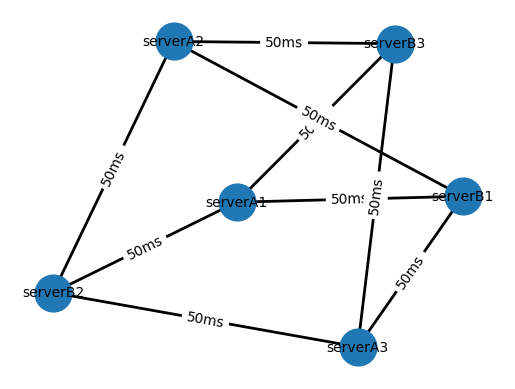

In [73]:
network_graph = NetworkGraph()

# Cluster A Servers
cluster_a_servers = ["serverA1", "serverA2", "serverA3"]
for server_id in cluster_a_servers:
    network_graph.add_server(Server(server_id, "192.168.1.x", 200, 300, 2000, 5))

# Cluster B Servers
cluster_b_servers = ["serverB1", "serverB2", "serverB3"]
for server_id in cluster_b_servers:
    network_graph.add_server(Server(server_id, "192.168.2.x", 200, 300, 2000, 5))

# Bottleneck Link - Connect clusters with higher latency / limited bandwidth
bottleneck_link_latency = 50  # Higher latency
bottleneck_link_bandwidth = 500  # Limited bandwidth
for server_a in cluster_a_servers:
    for server_b in cluster_b_servers:
        network_graph.connect_servers(server_a, server_b, bottleneck_link_latency, bottleneck_link_bandwidth)

# Initialize microservices with varied requirements
microservices = [
    Microservice("service1", "Auth", 50, 100, 500, 25),
    Microservice("service2", "Database", 100, 150, 1000, 30),
    Microservice("service3", "Cache", 75, 125, 750, 20),
    Microservice("service4", "Logging", 40, 90, 400, 18),
    Microservice("service5", "Payment", 60, 110, 600, 22),
    Microservice("service6", "Search", 85, 135, 850, 26),

]

# Initialize the environment and agent
env = MicroserviceDeploymentEnv(network_graph, microservices)
agent = DQN_Agent(num_features=3, num_actions=len(cluster_a_servers) + len(cluster_b_servers), device=device)

network_graph.visualize()


Episode 1, Total Reward: 10.34456767738943
Episode 2, Total Reward: 8.605423583873527
Episode 3, Total Reward: 8.847596566572221
Episode 4, Total Reward: 9.75225789315356
Episode 5, Total Reward: 12.440090588376789
Episode 6, Total Reward: 12.572382193585769
Episode 7, Total Reward: 10.097106499799418
Episode 8, Total Reward: 8.17934413371769
Episode 9, Total Reward: 9.565801388534135
Episode 10, Total Reward: 9.843207390102965
Episode 11, Total Reward: 6.5207420292806635
Episode 12, Total Reward: 11.498286676188883
Episode 13, Total Reward: 10.841787966647095
Episode 14, Total Reward: 10.846860179335023
Episode 15, Total Reward: 9.75225789315356
Episode 16, Total Reward: 8.905438688876748
Episode 17, Total Reward: 8.605423583873527
Episode 18, Total Reward: 9.275539585015311
Episode 19, Total Reward: 11.765876466022918
Episode 20, Total Reward: 10.200441686207686
Episode 21, Total Reward: 6.768704310262423
Episode 22, Total Reward: 7.572856180145211
Episode 23, Total Reward: 8.0619307

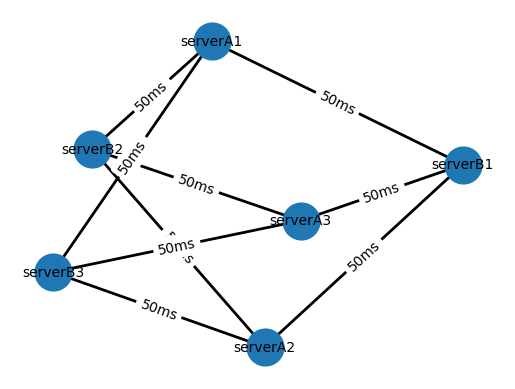

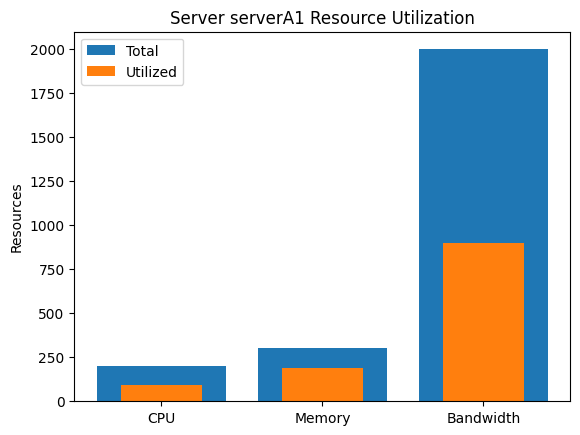

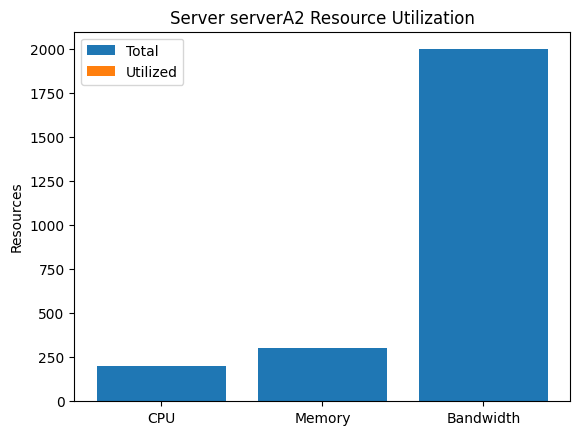

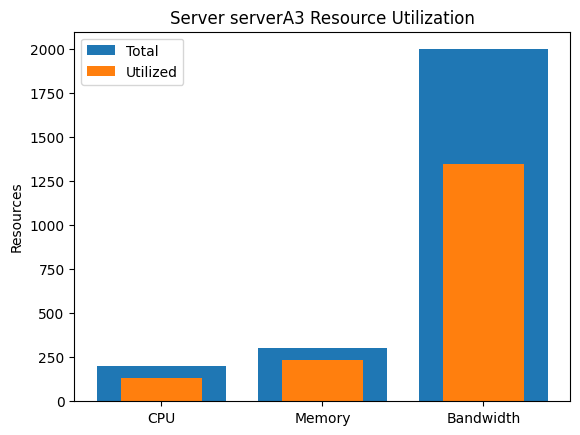

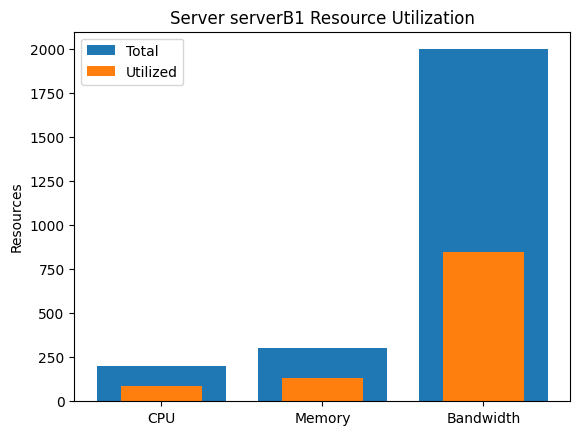

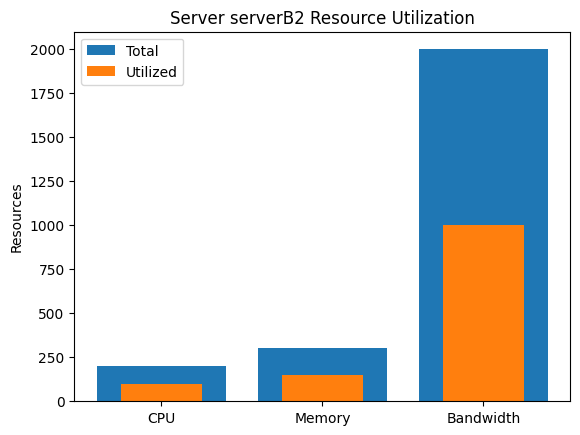

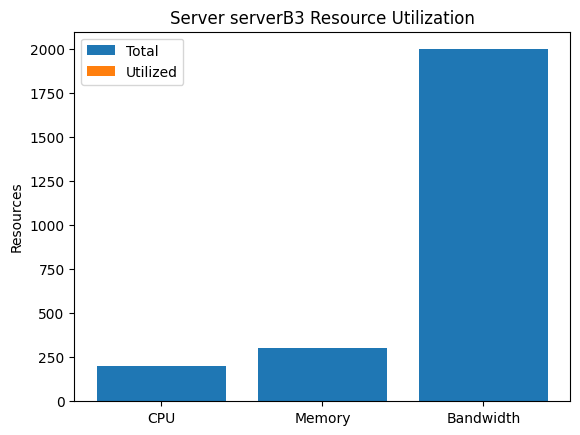

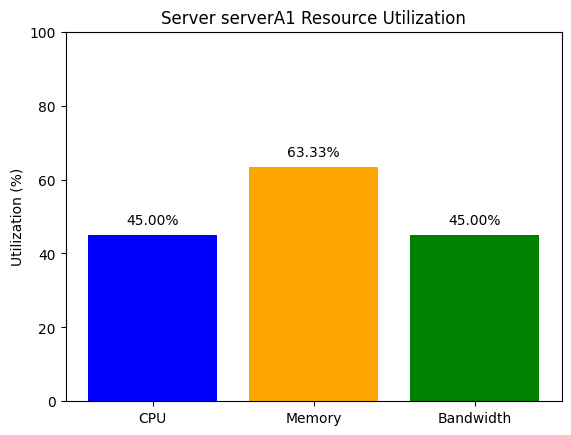

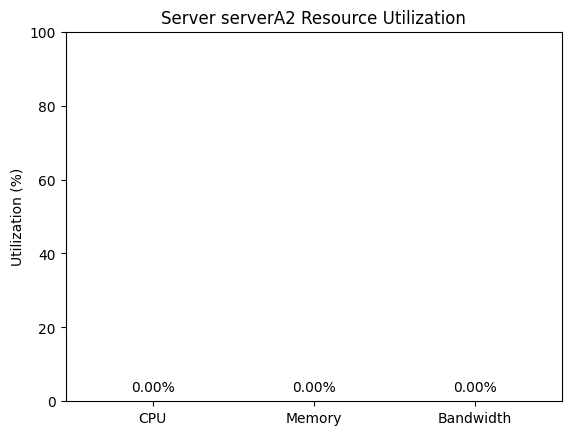

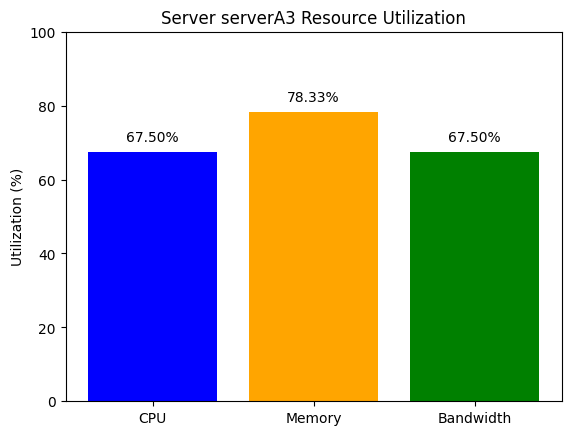

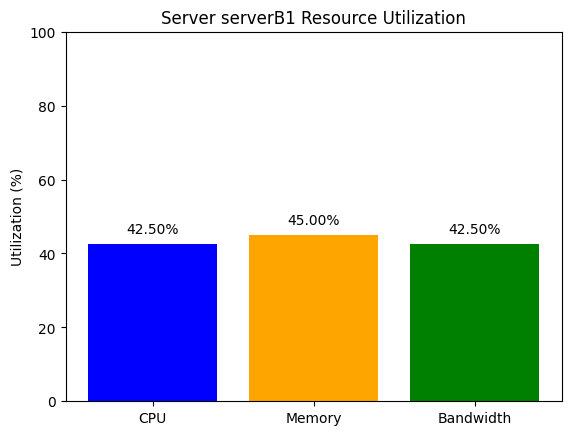

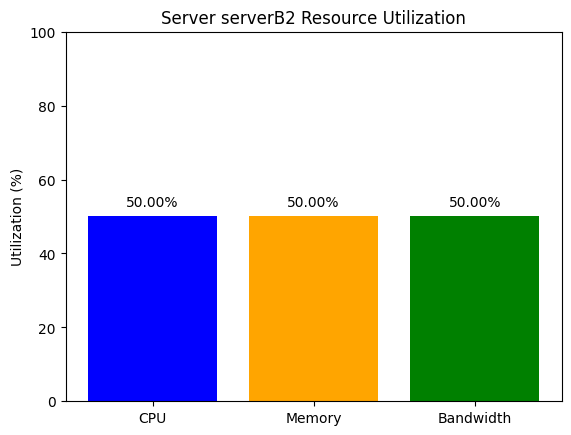

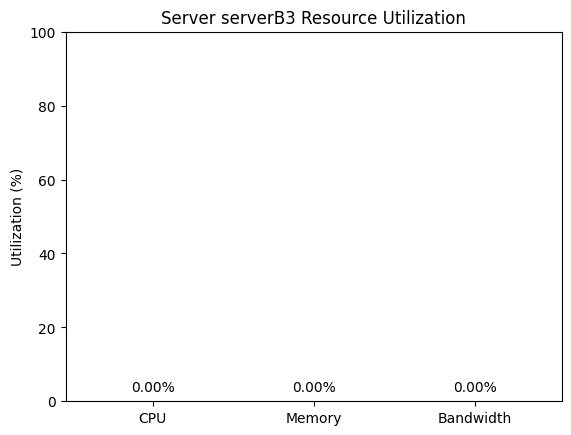


Listing all servers and deployed microservices:
Server serverA1 (192.168.1.x): Deployed Microservices -> ['service1', 'service4']
Server serverA2 (192.168.1.x): Deployed Microservices -> []
Server serverA3 (192.168.1.x): Deployed Microservices -> ['service3', 'service5']
Server serverB1 (192.168.2.x): Deployed Microservices -> ['service6']
Server serverB2 (192.168.2.x): Deployed Microservices -> ['service2']
Server serverB3 (192.168.2.x): Deployed Microservices -> []


In [74]:

num_episodes = 1000  # Number of episodes to run for testing
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        action_scalar = action.squeeze().item()
        next_state, reward, done = env.execute_action(action_scalar)
        total_reward += reward

        agent.memory.push(state, action, next_state, torch.tensor([reward], dtype=torch.float), done)
        state = next_state
        agent.optimize_model(batch_size=32)

    if episode % 10 == 0:
        agent.update_target_net()
    print(f'Episode {episode+1}, Total Reward: {total_reward}')

def list_servers_and_microservices(graph):
    print("\nListing all servers and deployed microservices:")
    for server_id, server in graph.nodes.items():
        deployed_services = [ms_id for ms_id in server.hosted_services]
        print(f"Server {server_id} ({server.ip_address}): Deployed Microservices -> {deployed_services}")

def plot_resource_utilization_for_all_servers(graph):
    for server_id, server in graph.nodes.items():
        utilized_cpu = server.total_cpu - server.available_cpu
        utilized_memory = server.total_memory - server.available_memory
        utilized_bandwidth = server.total_bandwidth - server.available_bandwidth

        resources = ['CPU', 'Memory', 'Bandwidth']
        total_resources = [server.total_cpu, server.total_memory, server.total_bandwidth]
        utilized_resources = [utilized_cpu, utilized_memory, utilized_bandwidth]

        fig, ax = plt.subplots()
        ax.bar(resources, total_resources, label='Total')
        ax.bar(resources, utilized_resources, label='Utilized', width=0.5)

        ax.set_ylabel('Resources')
        ax.set_title(f'Server {server_id} Resource Utilization')
        ax.legend()

        plt.show()

def plot_resource_utilization_for_all_servers_pct(graph):
    for server_id, server in graph.nodes.items():
        utilized_cpu_percent = ((server.total_cpu - server.available_cpu) / server.total_cpu) * 100 if server.total_cpu else 0
        utilized_memory_percent = ((server.total_memory - server.available_memory) / server.total_memory) * 100 if server.total_memory else 0
        utilized_bandwidth_percent = ((server.total_bandwidth - server.available_bandwidth) / server.total_bandwidth) * 100 if server.total_bandwidth else 0

        resources = ['CPU', 'Memory', 'Bandwidth']
        utilized_resources_percent = [utilized_cpu_percent, utilized_memory_percent, utilized_bandwidth_percent]

        fig, ax = plt.subplots()
        ax.bar(resources, utilized_resources_percent, color=['blue', 'orange', 'green'])

        ax.set_ylabel('Utilization (%)')
        ax.set_title(f'Server {server_id} Resource Utilization')
        ax.set_ylim(0, 100) 

       
        for i, utilization in enumerate(utilized_resources_percent):
            ax.text(i, utilization + 2, f'{utilization:.2f}%', ha='center', va='bottom')

        plt.show()


        
network_graph.visualize()
plot_resource_utilization_for_all_servers(network_graph)
plot_resource_utilization_for_all_servers_pct(network_graph)

# List servers and their deployed microservices in the new environment
list_servers_and_microservices(network_graph)
# Assuming 'agent.policy_net' is your model
torch.save(agent.policy_net.state_dict(), 'dqn_model.pth')


In [53]:
# Initialize a new network graph
test_network_graph = NetworkGraph()

# Add new servers with different configurations
test_network_graph.add_server(Server("test_server1", "192.168.1.1", 120, 240, 1100, 4))
test_network_graph.add_server(Server("test_server2", "192.168.1.2", 160, 260, 1600, 7))
test_network_graph.add_server(Server("test_server3", "192.168.1.3", 210, 310, 2100, 11))
test_network_graph.add_server(Server("test_server4", "192.168.1.4", 180, 290, 1400, 9))

# Optionally, you can add connections between servers if your model considers network latency or bandwidth for deployment decisions
# Example: test_network_graph.connect_servers("test_server1", "test_server2", latency=5, bandwidth=500)

# Initialize new microservices with different requirements
test_microservices = [
    Microservice("test_service1", "Web", 60, 110, 600, 20),
    Microservice("test_service2", "API", 90, 140, 900, 25),
    Microservice("test_service3", "Analytics", 80, 120, 800, 30),
    Microservice("test_service4", "Logging", 70, 130, 700, 15),
]

# Create a new test environment
test_env = MicroserviceDeploymentEnv(test_network_graph, test_microservices)

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = DQN_GCN(num_features=3, num_actions=3).to(device)
loaded_model.load_state_dict(torch.load('dqn_model.pth'))
loaded_model.eval()

# Assuming the environment and graph are already initialized and configured as desired
# For the test, we'll use the same environment setup as before
# Visualize resource utilization for the new set of servers
def list_servers_and_microservices(graph):
    print("\nListing all servers and deployed microservices:")
    for server_id, server in graph.nodes.items():
        deployed_services = [ms_id for ms_id in server.hosted_services]
        print(f"Server {server_id} ({server.ip_address}): Deployed Microservices -> {deployed_services}")

def plot_resource_utilization_for_all_servers(graph):
    for server_id, server in graph.nodes.items():
        utilized_cpu = server.total_cpu - server.available_cpu
        utilized_memory = server.total_memory - server.available_memory
        utilized_bandwidth = server.total_bandwidth - server.available_bandwidth

        resources = ['CPU', 'Memory', 'Bandwidth']
        total_resources = [server.total_cpu, server.total_memory, server.total_bandwidth]
        utilized_resources = [utilized_cpu, utilized_memory, utilized_bandwidth]

        fig, ax = plt.subplots()
        ax.bar(resources, total_resources, label='Total')
        ax.bar(resources, utilized_resources, label='Utilized', width=0.5)

        ax.set_ylabel('Resources')
        ax.set_title(f'Server {server_id} Resource Utilization')
        ax.legend()

        plt.show()

def plot_resource_utilization_for_all_servers_pct(graph):
    for server_id, server in graph.nodes.items():
        utilized_cpu_percent = ((server.total_cpu - server.available_cpu) / server.total_cpu) * 100 if server.total_cpu else 0
        utilized_memory_percent = ((server.total_memory - server.available_memory) / server.total_memory) * 100 if server.total_memory else 0
        utilized_bandwidth_percent = ((server.total_bandwidth - server.available_bandwidth) / server.total_bandwidth) * 100 if server.total_bandwidth else 0

        resources = ['CPU', 'Memory', 'Bandwidth']
        utilized_resources_percent = [utilized_cpu_percent, utilized_memory_percent, utilized_bandwidth_percent]

        fig, ax = plt.subplots()
        ax.bar(resources, utilized_resources_percent, color=['blue', 'orange', 'green'])

        ax.set_ylabel('Utilization (%)')
        ax.set_title(f'Server {server_id} Resource Utilization')
        ax.set_ylim(0, 100) 

       
        for i, utilization in enumerate(utilized_resources_percent):
            ax.text(i, utilization + 2, f'{utilization:.2f}%', ha='center', va='bottom')

        plt.show()
        
network_graph.visualize()
plot_resource_utilization_for_all_servers(test_network_graph)
plot_resource_utilization_for_all_servers_pct(test_network_graph)

# List servers and their deployed microservices in the new environment
list_servers_and_microservices(test_network_graph)


RuntimeError: Error(s) in loading state_dict for DQN_GCN:
	size mismatch for gcn.conv2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for gcn.conv2.lin.weight: copying a param with shape torch.Size([10, 16]) from checkpoint, the shape in current model is torch.Size([3, 16]).

Deploying service1 to server at index 0
Deployment result: 2.028595479208968
Deploying service2 to server at index 1
Deployment result: 2.669539120311383
Deploying service3 to server at index 0
Deployment result: -2
Deploying service4 to server at index 1
Deployment result: -2
Deploying service5 to server at index 1
Deployment result: -2
Deploying service6 to server at index 2
Deployment result: 1.7351764300057586

Testing special scenarios:

Deploying a microservice with requirements exceeding any server's capacity...
Deployment result for big service to server at index 0: -2

Attempting to deploy to an invalid server index...
Deployment result for invalid index: -5

Deploying microservice with specific requirements not met by the chosen server...
Deployment result for specific service to server at index 0 (requirements not met): -2


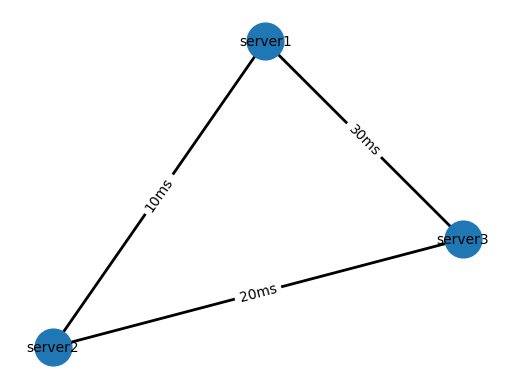


Listing all servers and deployed microservices:
Server server1 (10.0.0.1): Deployed Microservices -> ['service1']
Server server2 (10.0.0.2): Deployed Microservices -> ['service2']
Server server3 (10.0.0.3): Deployed Microservices -> ['service6']


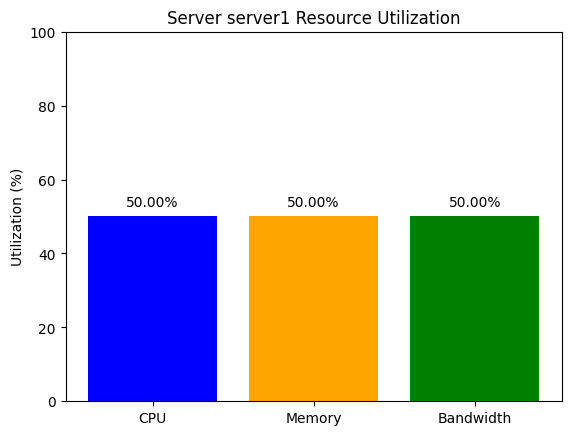

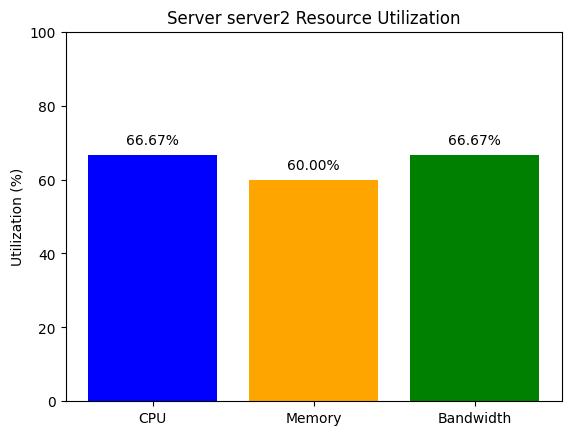

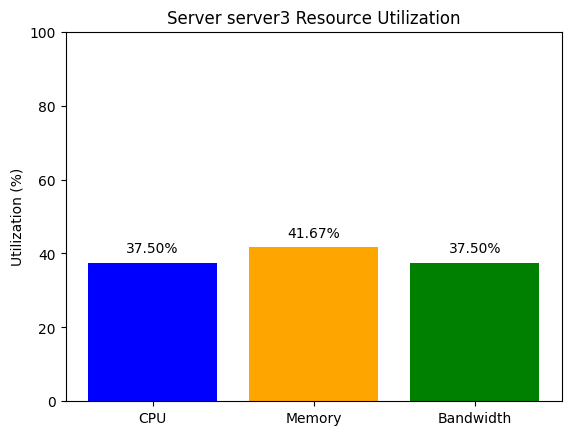

In [56]:
import random
import numpy as np
import matplotlib.pyplot as plt


network_graph = NetworkGraph()

network_graph.add_server(Server("server1", "10.0.0.1", 100, 200, 1000, 5))
network_graph.add_server(Server("server2", "10.0.0.2", 150, 250, 1500, 10))
network_graph.add_server(Server("server3", "10.0.0.3", 200, 300, 2000, 15))


network_graph.connect_servers("server1", "server2", latency=10, bandwidth=100)
network_graph.connect_servers("server2", "server3", latency=20, bandwidth=150)
network_graph.connect_servers("server1", "server3", latency=30, bandwidth=200)


microservice1 = Microservice("service1", "Auth", 50, 100, 500, 25)
microservice2 = Microservice("service2", "Database", 100, 150, 1000, 30)
microservice3 = Microservice("service3", "Cache", 75, 125, 750, 20)
microservice5 = Microservice("service5", "Au2323th", 50, 120, 523, 44)
microservice4 = Microservice("service4", "Dat2323abase", 100, 150, 1000, 30)
microservice6 = Microservice("service6", "Ca232che", 75, 125, 750, 20)

deployment_env = MicroserviceDeploymentEnv(network_graph, [microservice1, microservice2, microservice3, microservice4, microservice5, microservice6])

def plot_resource_utilization_for_all_servers(graph):
    for server_id, server in graph.nodes.items():
        utilized_cpu = server.total_cpu - server.available_cpu
        utilized_memory = server.total_memory - server.available_memory
        utilized_bandwidth = server.total_bandwidth - server.available_bandwidth

        resources = ['CPU', 'Memory', 'Bandwidth']
        total_resources = [server.total_cpu, server.total_memory, server.total_bandwidth]
        utilized_resources = [utilized_cpu, utilized_memory, utilized_bandwidth]

        fig, ax = plt.subplots()
        ax.bar(resources, total_resources, label='Total')
        ax.bar(resources, utilized_resources, label='Utilized', width=0.5)

        ax.set_ylabel('Resources')
        ax.set_title(f'Server {server_id} Resource Utilization')
        ax.legend()

        plt.show()

def plot_resource_utilization_for_all_servers_pct(graph):
    for server_id, server in graph.nodes.items():
        utilized_cpu_percent = ((server.total_cpu - server.available_cpu) / server.total_cpu) * 100 if server.total_cpu else 0
        utilized_memory_percent = ((server.total_memory - server.available_memory) / server.total_memory) * 100 if server.total_memory else 0
        utilized_bandwidth_percent = ((server.total_bandwidth - server.available_bandwidth) / server.total_bandwidth) * 100 if server.total_bandwidth else 0

        resources = ['CPU', 'Memory', 'Bandwidth']
        utilized_resources_percent = [utilized_cpu_percent, utilized_memory_percent, utilized_bandwidth_percent]

        fig, ax = plt.subplots()
        ax.bar(resources, utilized_resources_percent, color=['blue', 'orange', 'green'])

        ax.set_ylabel('Utilization (%)')
        ax.set_title(f'Server {server_id} Resource Utilization')
        ax.set_ylim(0, 100) 

       
        for i, utilization in enumerate(utilized_resources_percent):
            ax.text(i, utilization + 2, f'{utilization:.2f}%', ha='center', va='bottom')

        plt.show()

#ٍSucessful Deployments
for microservice in deployment_env.microservices:
    deployment_env.current_microservice = microservice
    action_index = random.randint(0, len(deployment_env.graph.nodes) - 1)
    print(f"Deploying {microservice.service_id} to server at index {action_index}")
    action_result = deployment_env.execute_action(action_index)
    print(f"Deployment result: {action_result}")

print("\nTesting special scenarios:")

# Simulate a failed deployment due to insufficient resources
print("\nDeploying a microservice with requirements exceeding any server's capacity...")
big_microservice = Microservice("big_service", "Big Data", 500, 600, 5000, 10)
deployment_env.current_microservice = big_microservice
action_index = random.randint(0, len(deployment_env.graph.nodes) - 1)
action_result = deployment_env.execute_action(action_index)
print(f"Deployment result for big service to server at index {action_index}: {action_result}")

# Simulate an invalid action
print("\nAttempting to deploy to an invalid server index...")
invalid_index = len(deployment_env.graph.nodes)  # Index out of range
deployment_env.current_microservice = microservice1  # Re-using microservice1 for this test
action_result = deployment_env.execute_action(invalid_index)
print(f"Deployment result for invalid index: {action_result}")

# Test deploying a microservice to a server that does not meet its requirements
print("\nDeploying microservice with specific requirements not met by the chosen server...")
specific_microservice = Microservice("specific_service", "Specific Task", 200, 300, 1500, 5)  # Requirements not met by at least one server
deployment_env.current_microservice = specific_microservice
action_index = 0 
action_result = deployment_env.execute_action(action_index)
print(f"Deployment result for specific service to server at index {action_index} (requirements not met): {action_result}")


network_graph.visualize()
def list_servers_and_microservices(graph):
    print("\nListing all servers and deployed microservices:")
    for server_id, server in graph.nodes.items():
        deployed_services = [ms_id for ms_id in server.hosted_services]
        print(f"Server {server_id} ({server.ip_address}): Deployed Microservices -> {deployed_services}")

list_servers_and_microservices(network_graph)
plot_resource_utilization_for_all_servers_pct(network_graph)

